This is a parameter search over the l1 regularization parameter for the NMF clustering algorithm.

This notebook follows from the CyTOF_NMF. The optimal value for the parameter is around 1-1.5. 
The algorithm also uses Non Negative Singular Value Decomposition to initialize the W and H matrices. This leads to high sparsity and a useful clustering algorithm, demonstrated by around 85% purity of the clusters. The purity metric does not consider the populations that are not labelled, as those don't belong to a single cluster.

In [1]:
import pandas as pd
from pandas import DataFrame as DF
from math import ceil
from time import time
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from filter_with_gmm import filter_with_gmm

In [2]:
# run transform.R before analysing the data.
df = read_csv("Levine_32dimtransform.csv")

In [3]:
markers = list(df)[4:36]

In [4]:
df[df[markers] < 0] = 0 # Non-negativity (no such thing as negative)
df.fillna(-1, inplace=True) 
# Nan replacement is necessary as np.unique thinks that all nans are unique 
# and the purity metric takes 1000s of iterations

In [5]:
def purity(true, pred, is_filtered=False):
    '''
    Implements the purity metric, removes the samples labelled as "not in any population".
    If filtering is set to true it keeps them.
    '''
    if np.isnan(np.sum(true)):
        where_is_nan = np.where(np.isnan(true))
        true[where_is_nan] = -1
    if is_filtered is False:
        to_keep = np.where(true != -1)
        true = true[to_keep]
        pred = pred[to_keep]
    unique_true = np.unique(true)
    unique_pred = np.unique(pred)
    assert len(true) > len(unique_true)*1.1, [len(true), np.unique(true), len(np.unique(true))]
    assert len(pred) > len(unique_pred)*1.1, [len(pred), np.unique(pred), len(np.unique(pred))]

    len_true = len(true)
    index = np.arange(len_true)

    max_intersections = []
    true_indexes_hash = {}

    for true_cluster in unique_true:
        intersections = []
        indexes = np.where(pred == true_cluster)

        for cluster in unique_pred:
            indexes_true = true_indexes_hash.get(cluster, np.where(true == cluster))
            true_indexes_hash.setdefault(cluster, indexes_true)
            intersection = len(np.intersect1d(indexes, indexes_true))
            intersections.append(intersection)
        else:
            max_intersections.append(max(intersections))
    return sum(max_intersections) / len_true


In [6]:
def eval_NMF_sparsity(range_object):
    """
    Uses the global object df
    which should be a non-negative dataframe with no NaNs in the 'label' column.
    """
    nmfs = []
    Ws = []
    preds = []
    purities = []
    true = df['label'].values
    true_unique = np.unique(true)
    assert len(true) > len(true_unique)
    for i in range_object:
        __nmf = NMF(n_components=15, init= "nndsvd", alpha=i, l1_ratio=1)
        __W = __nmf.fit_transform(df[markers].values)
        df['nmf{}'.format(i)] = __W.argmax(axis=1)
        assert len(df['nmf{}'.format(i)].values) > len(np.unique(df['nmf{}'.format(i)].values))
        purities.append(
            purity(true, df['nmf{}'.format(i)].values))
        nmfs.append(__nmf)
        Ws.append(__W)
    return purities, nmfs, Ws


def get_dict(l1_values:range, purities:list)->dict:
    return (
        {i: p for i, p in zip(l1_values, purities)})

In [7]:
get_range = lambda: range(1, 6)

purity1, nmfs, Ws = eval_NMF_sparsity(get_range())
get_dict(get_range(), purity1)

{1: 0.8523285725255317,
 2: 0.8471070413883129,
 3: 0.8398122552407279,
 4: 0.8308953390155878,
 5: 0.8198859709744298}

In [10]:
get_arange = lambda: np.arange(0.6, 1.4, 0.2)
purity1_lowl1, nmfs_lowl1, Ws_lowl1 = eval_NMF_sparsity(get_arange())
get_dict(get_arange(), purity1_lowl1)

{0.6: 0.8430757122014897,
 0.8: 0.8501881286953851,
 1.0: 0.8524533517622668,
 1.2000000000000002: 0.8525109421792214}

In [11]:
get_arange = lambda: np.arange(1.2, 2, 0.2)
purity1_gt1lt2, nmfs_gt1lt2, Ws_gt1lt2 = eval_NMF_sparsity(get_arange())
get_dict(get_arange(), purity1_gt1lt2)

{1.2: 0.8525397373876987,
 1.4: 0.8513399370344774,
 1.5999999999999999: 0.8502265223066882,
 1.7999999999999998: 0.8485372034093527}

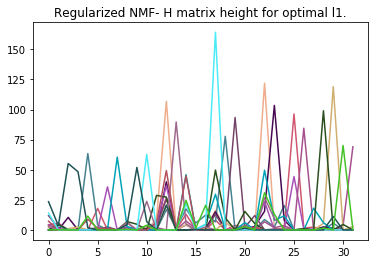

In [12]:
for comp in nmfs_gt1lt2[0].components_:
    plt.plot(comp, c=np.random.rand(3))
plt.title('Regularized NMF- H matrix height for optimal l1.')
plt.show()

As can be seen form the above figure, the values in the H matrix are higher and more more alike. For example the highest value, at 17 is closer to the next ones. This means that markers are more evenly spread. 
Alpha around 1.0-1.1 is best.